In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from orbit.models.ktrlite import KTRLiteMAP 
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.utils.dataset import load_iclaims
from orbit.utils.simulation import make_trend, make_seasonality, make_regression

## make data

In [2]:
n_obs = 365 * 3
seed = 2020
rw = make_trend(n_obs, rw_loc=0.01, rw_scale=0.1, seed=seed)
fs = make_seasonality(n_obs, seasonality=7, method='fourier', order=5, seed=seed)
# coef = [0.2, 0.1, 0.3]
# x, y, coef = make_regression(n_obs, coef, scale=2.0, seed=seed)

df = pd.DataFrame((rw + fs), columns=['response'])
df['date'] = pd.date_range(start='2016-01-01', periods=n_obs)

In [3]:
df.tail(5)

,response,date
1090,9.544337,2018-12-26
1091,9.207669,2018-12-27
1092,9.376404,2018-12-28
1093,9.541682,2018-12-29
1094,9.484031,2018-12-30


<AxesSubplot:>

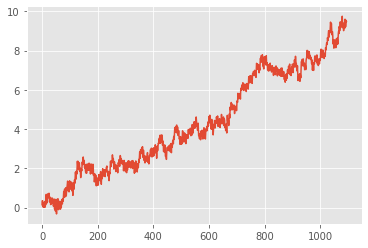

In [4]:
df['response'].plot()

In [5]:
# create a missing value in testing
df.loc[df.shape[0] - 3, 'response'] = np.nan
# create a missing value in training
df.loc[10, 'response'] = np.nan

## Create a BackTester

In [6]:
# instantiate a model
ktr = KTRLiteMAP(
    date_col='date',
    response_col='response',
    seasonality=[7],
)

In [7]:
bt = BackTester(
    model=ktr,
    df=df,
    n_splits=3,
    incremental_len=100,
    forecast_len=20,
)

In [8]:
bt.fit_predict()

In [9]:
predicted_df = bt.get_predicted_df()
predicted_df.head()

,date,split_key,training_data,actuals,prediction
0,2016-01-01,0,True,0.147641,0.183670
1,2016-01-02,0,True,0.352353,0.419051
2,2016-01-03,0,True,0.349375,0.205608
3,2016-01-04,0,True,0.036540,0.051833
4,2016-01-05,0,True,0.257475,0.247028


In [10]:
predicted_df.dtypes

date             datetime64[ns]
split_key                 int16
training_data              bool
actuals                 float64
prediction              float64
dtype: object

In [11]:
bt_score_df = bt.score(include_training_metrics=True)

In [12]:
bt_score_df.dtypes

metric_name            object
metric_values         float64
is_training_metric       bool
dtype: object

In [13]:
bt_score_df

,metric_name,metric_values,is_training_metric
0,smape,0.063866,False
1,wmape,0.065644,False
2,mape,0.061711,False
3,mse,0.392491,False
4,mae,0.517911,False
5,rmsse,NaN,False
6,smape,0.138849,True
7,wmape,0.065737,True
8,mape,0.402845,True
9,mse,0.101928,True


In [19]:
metric_vals

array([0.06386552, 0.06564403, 0.06171118, 0.39249146, 0.5179107 ,
       0.13884908, 0.06573734, 0.40284464, 0.10192776, 0.25409892])

## Backtest Get Models

In cases where `BackTester` doesn't cut it or for more custom use-cases, there's an interface to export the `TimeSeriesSplitter` and predicted data, as shown earlier. It's also possible to get each of the fitted models for deeper diving

In [37]:
fitted_models = bt.get_fitted_models()

In [14]:
model_1 = fitted_models[0]
model_1.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,trend.unemploy,Regular,-0.048042
1,trend.filling,Regular,-0.154309
2,trend.job,Regular,-0.014131


### Get TimeSeriesSplitter

BackTester composes a TimeSeriesSplitter within it, but TimeSeriesSplitter can also be created on its own as a standalone object. See section below on TimeSeriesSplitter for more details on how to use the splitter.

All of the additional TimeSeriesSplitter args can also be passed into BackTester on instantiation

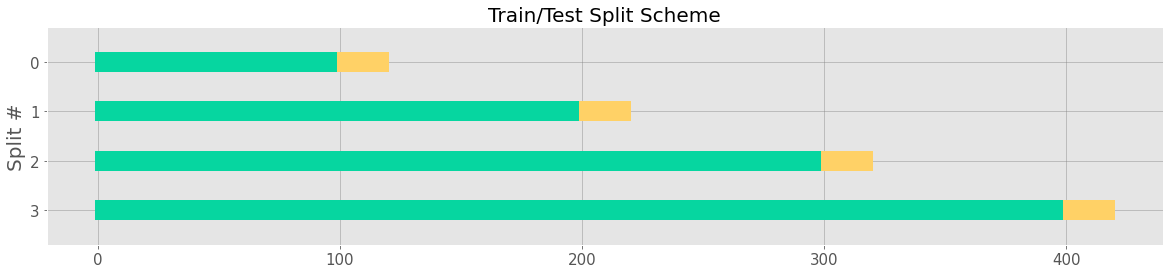

In [15]:
ts_splitter = bt.get_splitter()
ts_splitter.plot()

## Appendix

### Create a TimeSeriesSplitter

####  Expanding window

In [16]:
min_train_len = 380
forecast_len = 20
incremental_len = 20

In [17]:
ex_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                 window_type='expanding', date_col='week')

In [18]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start index: 0 Train end index: 379
Test start index: 380 Test end index: 399
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start index: 0 Train end index: 399
Test start index: 400 Test end index: 419
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start index: 0 Train end index: 419
Test start index: 420 Test end index: 439
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



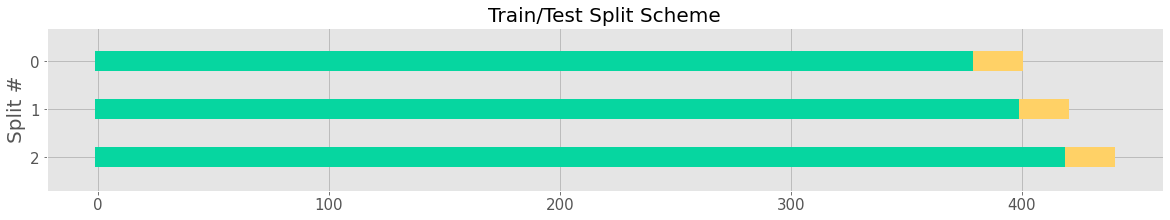

In [19]:
ex_splitter.plot()

#### Rolling window

In [20]:
roll_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                   window_type='rolling', date_col='week')

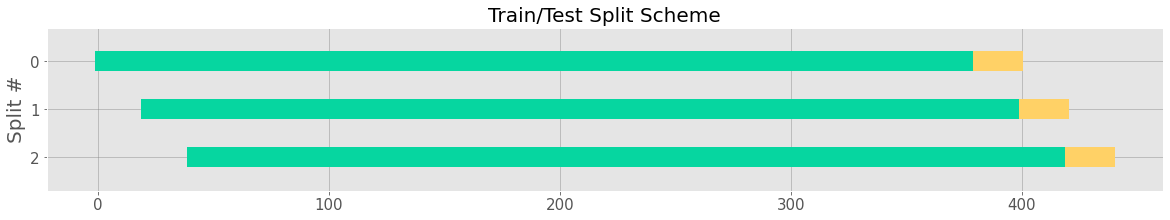

In [21]:
roll_splitter.plot()

#### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [22]:
ex_splitter2 = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, 
                                  n_splits=5, window_type='expanding', date_col='week')

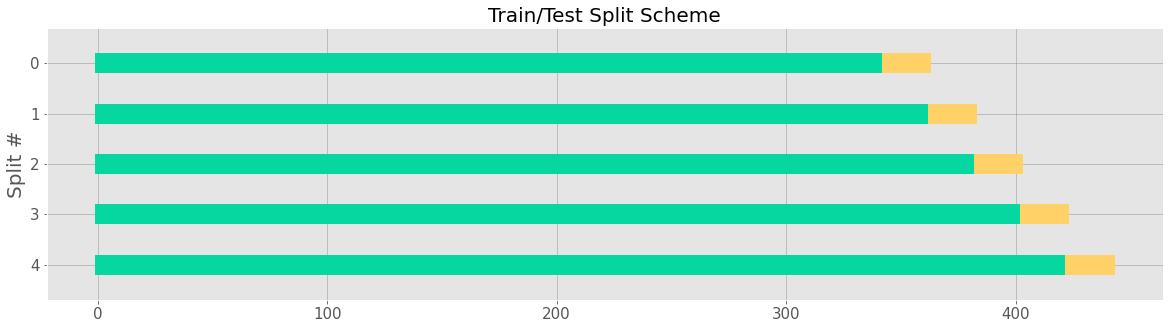

In [23]:
ex_splitter2.plot()